In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
!pip install sentence-transformers
!pip install tensor2tensor
!pip install six
import numpy as np
import os
import tarfile
import zipfile
import email
from bs4 import BeautifulSoup, Comment
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from sentence_transformers import SentenceTransformer
import copy
import functools
from six.moves import range
from tensor2tensor.layers import common_attention
from tensor2tensor.layers import common_layers
from tensor2tensor.models import transformer
from tensor2tensor.utils import registry
from tensor2tensor.utils import expert_utils
import networkx as nx
import io
import tqdm
import time

# U2GNN Tensorflow (unfinished)

In [ ]:
def universal_transformer_encoder(encoder_input, encoder_self_attention_bias, hparams, name="encoder", nonpadding=None, save_weights_to=None, make_image_summary=True):
  x = encoder_input
  attention_dropout_broadcast_dims = (
      common_layers.comma_separated_string_to_integer_list(
          getattr(hparams, "attention_dropout_broadcast_dims", "")))
  with tf.variable_scope(name):
    if nonpadding is not None:
      padding = 1.0 - nonpadding
    else:
      padding = common_attention.attention_bias_to_padding(
          encoder_self_attention_bias)
      nonpadding = 1.0 - padding
    pad_remover = None
    if hparams.use_pad_remover and not common_layers.is_xla_compiled():
      pad_remover = expert_utils.PadRemover(padding)

    ffn_unit = functools.partial(
        transformer_encoder_ffn_unit,
        hparams=hparams,
        nonpadding_mask=nonpadding,
        pad_remover=pad_remover)

    attention_unit = functools.partial(
        transformer_encoder_attention_unit,
        hparams=hparams,
        encoder_self_attention_bias=encoder_self_attention_bias,
        attention_dropout_broadcast_dims=attention_dropout_broadcast_dims,
        save_weights_to=save_weights_to,
        make_image_summary=make_image_summary)

    x, extra_output = universal_transformer_layer(
        x, hparams, ffn_unit, attention_unit, pad_remover=pad_remover)

    if hparams.get("use_memory_as_last_state", False):
      x = extra_output  # which is memory
    return common_layers.layer_preprocess(x, hparams), extra_output


def universal_transformer_decoder(decoder_input, encoder_output, decoder_self_attention_bias, encoder_decoder_attention_bias, hparams, name="decoder", nonpadding=None, save_weights_to=None, make_image_summary=True):
  x = decoder_input
  attention_dropout_broadcast_dims = (
      common_layers.comma_separated_string_to_integer_list(
          getattr(hparams, "attention_dropout_broadcast_dims", "")))
  with tf.variable_scope(name):
    ffn_unit = functools.partial(
        transformer_decoder_ffn_unit,
        hparams=hparams,
        nonpadding_mask=nonpadding)

    attention_unit = functools.partial(
        transformer_decoder_attention_unit,
        hparams=hparams,
        encoder_output=encoder_output,
        decoder_self_attention_bias=decoder_self_attention_bias,
        encoder_decoder_attention_bias=encoder_decoder_attention_bias,
        attention_dropout_broadcast_dims=attention_dropout_broadcast_dims,
        save_weights_to=save_weights_to,
        make_image_summary=make_image_summary)

    x, extra_output = universal_transformer_layer(
        x, hparams, ffn_unit, attention_unit)

    return common_layers.layer_preprocess(x, hparams), extra_output

In [ ]:
def universal_transformer_encoder(encoder_input, encoder_self_attention_bias, hparams, name="encoder", nonpadding=None, save_weights_to=None, make_image_summary=True):
  x = encoder_input
  attention_dropout_broadcast_dims = (common_layers.comma_separated_string_to_integer_list(getattr(hparams, "attention_dropout_broadcast_dims", "")))
  with tf.variable_scope(name):
    if nonpadding is not None:
      padding = 1.0 - nonpadding
    else:
      padding = common_attention.attention_bias_to_padding(encoder_self_attention_bias)
      nonpadding = 1.0 - padding
    pad_remover = None
    if hparams.use_pad_remover and not common_layers.is_xla_compiled():
      pad_remover = expert_utils.PadRemover(padding)
    ffn_unit = functools.partial(transformer_encoder_ffn_unit,hparams=hparams,nonpadding_mask=nonpadding,pad_remover=pad_remover)
    attention_unit = functools.partial(
        transformer_encoder_attention_unit,
        hparams=hparams,
        encoder_self_attention_bias=encoder_self_attention_bias,
        attention_dropout_broadcast_dims=attention_dropout_broadcast_dims,
        save_weights_to=save_weights_to,
        make_image_summary=make_image_summary)
    x, extra_output = universal_transformer_layer(x, hparams, ffn_unit, attention_unit, pad_remover=pad_remover)
    if hparams.get("use_memory_as_last_state", False):
      x = extra_output  # which is memory
    return common_layers.layer_preprocess(x, hparams), extra_output

In [ ]:
class UniversalTransformer1(transformer.Transformer):

  def encode(self, inputs, target_space, hparams, features=None, losses=None):
    del losses
    inputs = common_layers.flatten4d3d(inputs)
    encoder_input, self_attention_bias, encoder_decoder_attention_bias = (transformer.transformer_prepare_encoder(inputs, target_space, hparams, features=features))
    encoder_input = tf.nn.dropout(encoder_input, 1.0 - hparams.layer_prepostprocess_dropout)
    (encoder_output, encoder_extra_output) = (universal_transformer_encoder(encoder_input,self_attention_bias, hparams, nonpadding=transformer.features_to_nonpadding(features, "inputs"), save_weights_to=self.attention_weights))
    return encoder_output, encoder_decoder_attention_bias, encoder_extra_output

  def decode(self, decoder_input, encoder_output, encoder_decoder_attention_bias, decoder_self_attention_bias, hparams, cache=None, decode_loop_step=None, nonpadding=None, losses=None):
    del decode_loop_step
    del losses
    del cache
    decoder_input = tf.nn.dropout(decoder_input, 1.0 - hparams.layer_prepostprocess_dropout)
    (decoder_output, dec_extra_output) = (universal_transformer_decoder(decoder_input, encoder_output, decoder_self_attention_bias, encoder_decoder_attention_bias, hparams, nonpadding=nonpadding, save_weights_to=self.attention_weights))
    return tf.expand_dims(decoder_output, axis=2), dec_extra_output

  def body(self, features):
    hparams = self._hparams
    if hparams.add_position_timing_signal:
      hparams.pos = None
    if self.has_input:
      inputs = features["inputs"]
      target_space = features["target_space_id"]
      (encoder_output, encoder_decoder_attention_bias, enc_extra_output) = self.encode(inputs, target_space, hparams, features=features)
    else:
      (encoder_output, encoder_decoder_attention_bias, enc_extra_output) = (None, None, (None, None))
    targets = features["targets"]
    targets = common_layers.flatten4d3d(targets)
    (decoder_input, decoder_self_attention_bias) = transformer.transformer_prepare_decoder(targets, hparams, features=features)
    decoder_output, dec_extra_output = self.decode(decoder_input, encoder_output, encoder_decoder_attention_bias, decoder_self_attention_bias, hparams, nonpadding=transformer.features_to_nonpadding(features, "targets"))
    expected_attentions = features.get("expected_attentions")
    if expected_attentions is not None:
      attention_loss = common_attention.encoder_decoder_attention_loss(expected_attentions, self.attention_weights, hparams.expected_attention_loss_type, hparams.expected_attention_loss_multiplier)
      return decoder_output, {"attention_loss": attention_loss}
    if hparams.recurrence_type == "act" and hparams.act_loss_weight != 0:
      if self.has_input:
        enc_ponder_times, enc_remainders = enc_extra_output
        enc_act_loss = (hparams.act_loss_weight * tf.reduce_mean(enc_ponder_times + enc_remainders))
      else:
        enc_act_loss = 0.0
      (dec_ponder_times, dec_remainders) = dec_extra_output
      dec_act_loss = (hparams.act_loss_weight * tf.reduce_mean(dec_ponder_times + dec_remainders))
      act_loss = enc_act_loss + dec_act_loss
      tf.contrib.summary.scalar("act_loss", act_loss)
      return decoder_output, {"act_loss": act_loss}
    return decoder_output

  def _greedy_infer(self, features, decode_length, use_tpu=False):
    return (self._slow_greedy_infer_tpu(features, decode_length) if use_tpu else self._slow_greedy_infer(features, decode_length))

  def _beam_decode(self, features, decode_length, beam_size, top_beams, alpha):
    return self._beam_decode_slow(features, decode_length, beam_size, top_beams, alpha)
    
@registry.register_model
class UniversalTransformerEncoder1(transformer.Transformer):
  def encode(self, inputs, target_space, hparams, features=None, losses=None):
    del losses
    inputs = common_layers.flatten4d3d(inputs)
    (encoder_input, self_attention_bias, _) = (transformer.transformer_prepare_encoder(inputs, target_space, hparams))
    encoder_input = tf.nn.dropout(encoder_input, 1.0 - hparams.layer_prepostprocess_dropout)
    (encoder_output, encoder_extra_output) = (universal_transformer_encoder(encoder_input,self_attention_bias, hparams, nonpadding=transformer.features_to_nonpadding(features, "inputs"), save_weights_to=self.attention_weights))
    return encoder_output, encoder_extra_output

  def body(self, features):
    hparams = self._hparams
    inputs = features["inputs"]
    target_space = features["target_space_id"]
    encoder_output, enc_extra_output = self.encode(inputs, target_space, hparams, features=features)
    encoder_output = tf.expand_dims(encoder_output, 2)
    if hparams.recurrence_type == "act" and hparams.act_loss_weight != 0:
      ponder_times, remainders = enc_extra_output
      act_loss = hparams.act_loss_weight * tf.reduce_mean(ponder_times + remainders)
      tf.contrib.summary.scalar("act_loss", act_loss)
      return encoder_output, {"act_loss": act_loss}
    return encoder_output

def update_hparams_for_universal_transformer(hparams):
  hparams.daisy_chain_variables = False 
  hparams.add_hparam("mix_with_transformer", None)
  hparams.add_hparam("num_mixedin_layers", 2)
  hparams.add_hparam("recurrence_type", "basic")
  hparams.add_hparam("num_rec_steps", hparams.num_hidden_layers)
  hparams.add_hparam("add_position_timing_signal", True)
  if hparams.add_position_timing_signal:
    hparams.pos = None
  hparams.add_hparam("position_start_index", None)
  hparams.add_hparam("add_step_timing_signal", True)
  hparams.add_hparam("step_timing_signal_type", "learned")
  hparams.add_hparam("add_or_concat_timing_signal", "add")
  hparams.add_hparam("add_sru", False)
  hparams.add_hparam("transformer_ffn_type", "fc")
  hparams.add_hparam("transform_bias_init", -1.0)
  hparams.add_hparam("couple_carry_transform_gates", True)
  hparams.add_hparam("depth_embedding", True)
  hparams.add_hparam("dwa_elements", True)
  hparams.add_hparam("gate_ffn_layer", "dense")
  hparams.add_hparam("lstm_forget_bias", 1.0)
  hparams.add_hparam("use_memory_as_final_state", True)
  hparams.add_hparam("add_ffn_unit_to_the_transition_function", False)
  hparams.add_hparam("act_type", "basic")
  hparams.add_hparam("act_max_steps", 2 * hparams.num_hidden_layers)
  hparams.add_hparam("act_halting_bias_init", 1.0)
  hparams.add_hparam("act_epsilon", 0.01)
  hparams.add_hparam("act_loss_weight", 0.01)
  return hparams

@registry.register_hparams
def universal_transformer_small1():
  hparams = transformer.transformer_base()
  hparams = update_hparams_for_universal_transformer(hparams)
  return hparams

NameError: ignored

In [ ]:
class UGformerV1(object):
    def __init__(self, feature_dim_size, hparams_batch_size, ff_hidden_size, seq_length, num_classes, num_self_att_layers, num_GNN_layers=1):
        self.input_x = tf.compat.v1.placeholder(tf.int32, [None, seq_length], name="input_x")
        self.graph_pool = tf.compat.v1.sparse_placeholder(tf.float32, [None, None], name="graph_pool")
        self.X_concat = tf.compat.v1.placeholder(tf.float32, [None, feature_dim_size], name="X_concat")
        self.one_hot_labels = tf.compat.v1.placeholder(tf.float32, [None, num_classes], name="one_hot_labels")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        #Inputs for Universal Transformer
        self.input_UT = tf.nn.embedding_lookup(self.X_concat, self.input_x)
        self.input_UT = tf.reshape(self.input_UT, [-1, seq_length, 1, feature_dim_size])

        #Matrix weights in Universal Transformer are shared across each attention layer (timestep), while they are not in Transformer.
        #It's optional to use Transformer Encoder.
        self.hparams = universal_transformer_small1()
        self.hparams.hidden_size = feature_dim_size
        self.hparams.batch_size = hparams_batch_size * seq_length
        self.hparams.max_length = seq_length
        self.hparams.num_hidden_layers = num_self_att_layers  # Number of attention layers: the number T of timesteps in Universal Transformer
        self.hparams.num_heads = 1  # due to the fact that the feature embedding sizes are various
        self.hparams.filter_size = ff_hidden_size
        self.hparams.use_target_space_embedding = False
        self.hparams.pos = None
        self.hparams.add_position_timing_signal = False
        self.hparams.add_step_timing_signal = False
        self.hparams.add_sru = False
        self.hparams.add_or_concat_timing_signal = None

        # Construct k GNN layers
        self.scores = 0
        for layer in range(num_GNN_layers):  # the number k of multiple stacked layers, each stacked layer includes a number of self-attention layers
            # Universal Transformer Encoder
            self.ute = universal_transformer_modified.UniversalTransformerEncoder1(self.hparams, mode=tf.estimator.ModeKeys.TRAIN)
            self.output_UT = self.ute({"inputs": self.input_UT, "targets": 0, "target_space_id": 0})[0]
            self.output_UT = tf.squeeze(self.output_UT, axis=2)
            #
            self.output_target_node = tf.split(self.output_UT, num_or_size_splits=seq_length, axis=1)[0]
            self.output_target_node = tf.squeeze(self.output_target_node, axis=1)
            #input for next GNN hidden layer
            self.input_UT = tf.nn.embedding_lookup(self.output_target_node, self.input_x)
            self.input_UT = tf.reshape(self.input_UT, [-1, seq_length, 1, feature_dim_size])
            # graph pooling
            self.graph_embeddings = tf.compat.v1.sparse_tensor_dense_matmul(self.graph_pool, self.output_target_node)
            self.graph_embeddings = tf.nn.dropout(self.graph_embeddings, keep_prob=self.dropout_keep_prob)

            # Concatenate graph representations from all GNN layers
            with tf.variable_scope("layer_%d" % layer):
                W = tf.compat.v1.get_variable(shape=[feature_dim_size, num_classes],
                                              initializer=tf.contrib.layers.xavier_initializer(),
                                              name="W_layer_%d" % layer)
                b = tf.Variable(tf.zeros([num_classes]))
                self.scores += tf.compat.v1.nn.xw_plus_b(self.graph_embeddings, W, b)

        # Final predictions
        self.predictions = tf.argmax(self.scores, 1, name="predictions")
        # Calculate mean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(logits=self.scores, labels=label_smoothing(self.one_hot_labels))
            self.total_loss = tf.reduce_mean(losses)

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.one_hot_labels, 1))
            self.accuracy = tf.reduce_sum(tf.cast(correct_predictions, "float"), name="accuracy")

        self.saver = tf.compat.v1.train.Saver(tf.global_variables(), max_to_keep=500)
        tf.logging.info('Seting up the main structure')

def label_smoothing(inputs, epsilon=0.1):
    V = inputs.get_shape().as_list()[-1]  # number of channels
    return ((1 - epsilon) * inputs) + (epsilon / V)

# U2GNN Pytorch

In [3]:
class UGformerV1(nn.Module):
  def __init__(self, feature_dim_size, ff_hidden_size, num_classes, num_self_att_layers, dropout, num_GNN_layers):
    super(UGformerV1, self).__init__()
    self.feature_dim_size = feature_dim_size
    self.ff_hidden_size = ff_hidden_size
    self.num_classes = num_classes
    self.num_self_att_layers = num_self_att_layers
    self.num_GNN_layers = num_GNN_layers
    self.ugformer_layers = torch.nn.ModuleList()
    for _ in range(self.num_GNN_layers):
        encoder_layers = TransformerEncoderLayer(d_model=self.feature_dim_size, nhead=1, dim_feedforward=self.ff_hidden_size, dropout=0.5)
        self.ugformer_layers.append(TransformerEncoder(encoder_layers, self.num_self_att_layers))
    self.predictions = torch.nn.ModuleList()
    self.dropouts = torch.nn.ModuleList()
    for _ in range(self.num_GNN_layers):
        self.predictions.append(nn.Linear(self.feature_dim_size, self.num_classes))
        self.dropouts.append(nn.Dropout(dropout))

  def forward(self, input_x, graph_pool, X_concat):
    prediction_scores = 0
    input_Tr = F.embedding(input_x, X_concat)
    for layer_idx in range(self.num_GNN_layers):
        output_Tr = self.ugformer_layers[layer_idx](input_Tr)[0]
        input_Tr = F.embedding(input_x, output_Tr)
        graph_embeddings = torch.spmm(graph_pool, output_Tr)
        graph_embeddings = self.dropouts[layer_idx](graph_embeddings)
        prediction_scores += self.predictions[layer_idx](graph_embeddings)
        return prediction_scores

def label_smoothing(true_labels: torch.Tensor, classes: int, smoothing=0.1):
    assert 0 <= smoothing < 1
    confidence = 1.0 - smoothing
    label_shape = torch.Size((true_labels.size(0), classes))
    with torch.no_grad():
        true_dist = torch.empty(size=label_shape, device=true_labels.device)
        true_dist.fill_(smoothing / (classes - 1))
        true_dist.scatter_(1, true_labels.data.unsqueeze(1), confidence)
    return true_dist

# Email preprocessing
\

In [4]:
NODE_EMBEDDING_LENGTH = 1280
text_encoder = SentenceTransformer('distiluse-base-multilingual-cased', device='cuda')
attachment_encoder = tf.keras.applications.MobileNetV3Small(weights='imagenet', input_shape=(224, 224, 3), include_top = False)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/607 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/528 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

6709248/6698480 [==============================] - 0s 0us/step


In [5]:
class S2VGraph(object):
    def __init__(self):
        self.label = 0
        self.g = 0
        self.neighbors = []
        self.node_features = 0
        self.edge_mat = 0
        self.max_neighbour = 0
        

In [25]:
from email.iterators import _structure
from contextlib import redirect_stdout
import io

def tag_visible(element):
  if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]'] or isinstance(element, Comment):
      return False
  else:
      return True

def process_html(txt):
  soup = BeautifulSoup(txt, 'html.parser')
  texts = soup.findAll(text=True)
  visible_texts = filter(tag_visible, texts)
  return ' '.join(visible_texts) 

def get_structure(msg):
  with io.StringIO() as buf, redirect_stdout(buf):
    _structure(msg)
    ans = buf.getvalue()
  return ans.replace("    ", '\t').split('\n')

def encode_text(part):
  text = part.get_payload(decode=True).decode('latin-1')
  if bool(BeautifulSoup(text, "html.parser").find()):
    text = process_html(text)
  return text_encoder.encode(text)

def encode_image(part):
  if part.get_content_subtype() != 'gif':
    with open('/content/attachment.' + part.get_content_subtype(), "wb+") as f:
      f.write(part.get_payload(decode=True))
    try:
      image = cv2.imread('/content/attachment.' + art.get_content_subtype())
      image = cv2.resize(image, (224, 224))
      image = np.reshape(image, (1, 224, 224, 3))
    except Exception:
      return np.zeros(NODE_EMBEDDING_LENGTH)
    return attachment_encoder.predict(image)
  return np.zeros(NODE_EMBEDDING_LENGTH)

def get_node_features(part):
    if part.get_content_maintype() == 'text' or part.get_content_type() == 'plain':
      features = encode_text(part)
    elif part.get_content_maintype() == 'image':
      features = encode_image(part)
    else:
      features = np.zeros(NODE_EMBEDDING_LENGTH)
    return np.pad(features, (0, NODE_EMBEDDING_LENGTH - len(features)))
      

def process_email(msg, label):
  struct = get_structure(msg)
  g = nx.Graph()
  cur_graph = S2VGraph()
  node_idx = 0
  stack = []
  node_features = np.zeros((len(struct), NODE_EMBEDDING_LENGTH))
  for part in msg.walk():
    g.add_node(node_idx, payload=part.get_content_type()) 
    cur_depth = struct[node_idx].count('\t')
    while len(stack) > cur_depth:
      stack.pop()
    if len(stack) != 0:
      parent_idx = stack.pop()
      g.add_edge(parent_idx, node_idx)
      stack.append(parent_idx)
    stack.append(node_idx)
    node_idx += 1
    node_features[node_idx, :] = get_node_features(part)
  cur_graph.g = g
  cur_graph.label = label
  cur_graph.node_features = node_features
  cur_graph.neighbours = [[] for i in range(len(cur_graph.g))]
  for i, j in cur_graph.g.edges():
    cur_graph.neighbours[i].append(j)
    cur_graph.neighbours[j].append(i)
  degree_list = []
  for i in range(len(cur_graph.g)):
    degree_list.append(len(cur_graph.neighbours[i]))
  cur_graph.max_neighbour = max(degree_list)
  if len(cur_graph.g.edges()) != 0:
    edges = [list(pair) for pair in cur_graph.g.edges()]
    edges.extend([[i, j] for j, i in edges])
  else:
    edges = [[]]
  deg_list = list(dict(cur_graph.g.degree(range(len(cur_graph.g)))).values())
  cur_graph.edge_mat = np.transpose(np.array(edges, dtype=np.int32), (1,0))
  return cur_graph


def get_processed_arr(raw_emails, classes):
  start_time = time.time()
  input_graphs = []
  for i in tqdm.tqdm(range(len(raw_emails))):
    input_graphs.append(process_email(email.message_from_string(raw_emails[i]), classes[i]))
  total_time = time.time() - start_time
  print(f"Total preprocessing time: {total_time}   \nAverage preprocessing time: {total_time / len(raw_emails)}")
  return input_graphs

# SpamAssassin

In [7]:
spamassassin = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Coursework/datasets/spamassassin.zip', 'r')
spamassassin.extractall()

In [8]:
def extract_emails_spamassassin():
  spamdir = '/content/spam_2/spam_2'
  ehamdir = '/content/easy_ham/easy_ham'
  hhamdir = '/content/hard_ham/hard_ham'
  nspam = len(os.listdir(spamdir))
  neham = len(os.listdir(ehamdir))
  nhham = len(os.listdir(hhamdir))
  sa_classes = np.concatenate((np.ones(nspam), np.zeros(neham + nhham)))
  sa_texts = np.empty(nspam + nhham + neham, dtype=object)
  for i, filename in enumerate(os.listdir(spamdir)):
    curr_email = open(os.path.join(spamdir, filename), encoding='latin-1')
    sa_texts[i] = curr_email.read()
  for i, filename in enumerate(os.listdir(ehamdir)):
    curr_email = open(os.path.join(ehamdir, filename), encoding='latin-1')
    sa_texts[i + nspam] = curr_email.read()
  for i, filename in enumerate(os.listdir(hhamdir)):
    curr_email = open(os.path.join(hhamdir, filename), encoding='latin-1')
    sa_texts[i + nspam + neham] = curr_email.read()
  return sa_texts, sa_classes

In [10]:
sa_raw_texts, sa_classes = extract_emails_spamassassin()

In [26]:
sa_graphs = get_processed_arr(sa_raw_texts, sa_classes)

100%|██████████| 4198/4198 [01:32<00:00, 45.58it/s]

Total preprocessing time: 92.10696125030518   
Average preprocessing time: 0.021940676810458592


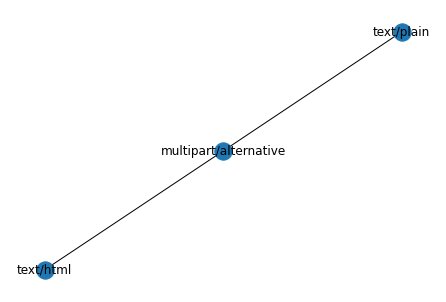

In [ ]:
_structure(email.message_from_string(sa_raw_texts[3]))

multipart/alternative
    text/plain
    text/html


In [ ]:
print(tmp.strip().split('\n'))

['multipart/alternative', '\ttext/plain', '\ttext/html']
